# `dask` avancé

Dans cette séance, vous découvrirez deux collections spécifiquement définies en `dask` : `dask.array` qui est un remplacement aux _numpy arrays_ et `dask.DataFrame` qui est la version `dask` des _dataframes_ pandas.

## Partie 1 : `dask.array`

La classe `dask.array` implémente un sous-ensemble des fonctionnalités des _numpy arrays_ à l'aide d'algorithmes par blocs, en découpant les tableaux trop grands en sous-tableaux.
Cela permet d'effectuer des calculs sur des tableaux plus grand que la mémoire disponible en utilisant tous les coeurs disponibles.
Ces calculs sont gérés, en interne, à l'aide de graphes de calcul Dask.

**Question.** En combien de blocs est divisé le `dask.array` créé par le code ci-dessous ?

In [1]:
import numpy as np
import dask.array as da

a_da = da.ones(10, chunks=5)
a_da

dask.array<ones_like, shape=(10,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

Ainsi, le code ci-dessous :

In [2]:
a_da.sum().compute()

10.0

est équivalent, si l'on se restreignait à utiliser des _numpy arrays_, à :

In [3]:
a_np = np.ones(10)
a_np[:5].sum() + a_np[5:].sum()

10.0

(sauf que le code numpy implique de pouvoir stocker en mémoire le tableau en question).

**Question.** Quelle est la mémoire vive disponible sur votre machine ? Sachant qu'un entier est codé sur 32 bits, soit 4 octets, tentez d'initialiser un vecteur de 1 en numpy tel qu'il ne puisse pas tenir dans la mémoire de votre machine (faites par exemple en sorte que sa taille soit le double de votre RAM). Votre notebook plante-t-il ? Pourquoi ?

In [4]:
%%time

# Ici, 32Go de mémoire, soit 32 * 1024 * 1024 * 1024 octets
octets_max = 32 * 1024 * 1024 * 1024
nb_entiers_max = octets_max // 4

X_np = np.ones(2 * nb_entiers_max, )

CPU times: user 4.82 s, sys: 10.6 s, total: 15.4 s
Wall time: 19.4 s


**Question.** Faites la même chose en `dask` et comparez les temps d'exécution. Qu'est-ce qui justifie cette différence à votre avis ?

In [5]:
%%time

X_da = da.ones(2 * nb_entiers_max, )

CPU times: user 860 µs, sys: 915 µs, total: 1.78 ms
Wall time: 1.77 ms


**Question.** Calculez maintenant, en numpy d'une part et en dask d'autre part, la somme de ces vecteurs, et comparez les temps de calcul.

In [6]:
%%time

X_np.sum()

CPU times: user 7.05 s, sys: 21.4 s, total: 28.5 s
Wall time: 1min 30s


17179869184.0

In [7]:
%%time

X_da.sum().compute()

CPU times: user 3.02 s, sys: 43.5 ms, total: 3.06 s
Wall time: 411 ms


17179869184.0

**Question.** Visualisez le graphe Dask de calcul de cette somme. Quelle semble être la stratégie utilisée pour calculer cette somme ?

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.212402 to fit


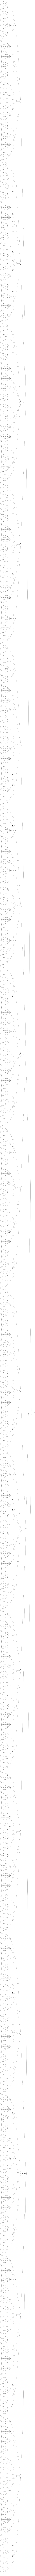

In [8]:
X_da.sum().visualize(rankdir="LR")

La plupart des fonctions que vous connaissez en numpy sont également disponibles en Dask.

**Question.** Définissez une matrice `X` (au format _dask array_) de taille 30 000 x 30 000 d'éléments tirés selon une loi normale centrée réduite (vous utiliserez [`da.random.normal`](https://docs.dask.org/en/stable/generated/dask.array.random.normal.html)). Calculez la moyenne selon l'axe `axis=1` de la somme de `X` et de sa transposée.

In [9]:
X = da.random.normal(0., 1., size=(30000, 30000))
(X + X.T).mean(axis=1).compute()

array([ 0.00939356,  0.00585867,  0.00082044, ...,  0.01019194,
        0.00045259, -0.00450685])

### Influence de la taille des blocs

Il est possible de connaître la taille des blocs utilisés à l'aide de :

In [10]:
X.chunksize

(4096, 4096)

Ici, on a, sur chaque dimension, des blocs de taille 4096 (c'est-à-dire qu'ils sont constitués de sous-matrices de taille 4096x4096 sauf pour la dernière ligne/colonne qui peut recevoir des blocs plus petits).

On peut demander de changer cette taille avec :

In [11]:
X = X.rechunk({0: 8192, 1: 8192})

**Question.** Évaluer l'influence de la taille des blocs sur l'efficacité du calcul ci-dessus.

In [12]:
X = da.random.normal(0., 1., size=(30000, 30000))

X1 = X.rechunk({0: 256, 1: 256})
X2 = X.rechunk({0: 8192, 1: 8192})
X3 = X.rechunk({0: 32768, 1: 32768})

In [13]:
%%time

(X1 + X1.T).mean(axis=1).compute()

CPU times: user 21 s, sys: 1.97 s, total: 23 s
Wall time: 5.17 s


array([-4.84044474e-04, -2.79658865e-05,  1.00571085e-04, ...,
       -8.55090791e-03,  5.53811441e-03,  7.43775282e-03])

In [14]:
%%time

(X2 + X2.T).mean(axis=1).compute()

CPU times: user 21.1 s, sys: 17.6 s, total: 38.8 s
Wall time: 7.04 s


array([-4.84044474e-04, -2.79658865e-05,  1.00571085e-04, ...,
       -8.55090791e-03,  5.53811441e-03,  7.43775282e-03])

In [15]:
%%time

(X3 + X3.T).mean(axis=1).compute()

CPU times: user 20.1 s, sys: 15.6 s, total: 35.7 s
Wall time: 54.1 s


array([-4.84044474e-04, -2.79658865e-05,  1.00571085e-04, ...,
       -8.55090791e-03,  5.53811441e-03,  7.43775282e-03])

## Partie 2 : `dask.DataFrame`

Dans cette partie, vous allez manipuler des Data Frames `dask` pour mieux comprendre ce qui les différencie des Data Frames `pandas`.
Pour commencer, vous allez travailler sur des données issues du fichier `data/nycflights.tar.gz`.
Décompressez cette archive dans votre sous-dossier `data/` de manière à obtenir 10 fichiers CSV dans le dossier `data/nycflights`.

**Question.** Que fait le code suivant ?

In [16]:
import pandas as pd
import os

filenames = [os.path.join("data", "nycflights", fname) 
             for fname in os.listdir(os.path.join("data", "nycflights")) 
             if fname.endswith(".csv")]
filenames

['data/nycflights/1990.csv',
 'data/nycflights/1991.csv',
 'data/nycflights/1993.csv',
 'data/nycflights/1992.csv',
 'data/nycflights/1996.csv',
 'data/nycflights/1997.csv',
 'data/nycflights/1995.csv',
 'data/nycflights/1994.csv',
 'data/nycflights/1999.csv',
 'data/nycflights/1998.csv']

In [17]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn, 
                     parse_dates={"Date": [0, 1, 2]},
                     dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool})
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
mean

CPU times: user 1.91 s, sys: 270 ms, total: 2.18 s
Wall time: 2.2 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

**Question.** Parallélisez ce code avec `dask.delayed`. Quel gain, en temps de calcul, obtenez-vous ?

In [18]:
%%time

import dask

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = dask.delayed(pd.read_csv)(fn, 
                     parse_dates={"Date": [0, 1, 2]},
                     dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool})
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = (total_delays / n_flights).compute()
mean

CPU times: user 2.51 s, sys: 411 ms, total: 2.92 s
Wall time: 1.31 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

**Question.** Modifiez ce code pour utiliser un `dask.DataFrame`.

In [19]:
import dask.dataframe as dd

In [20]:
%%time

ddf = dd.read_csv(os.path.join("data", "nycflights", "*.csv"),
                  parse_dates={"Date": [0, 1, 2]},
                  dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool})
    
# Groupby origin airport
by_origin = ddf.groupby('Origin')

# Sum of all departure delays by origin
total = by_origin.DepDelay.sum()

# Number of flights by origin
n_flights = by_origin.DepDelay.count()
mean = (total / n_flights).compute()
mean

CPU times: user 2.56 s, sys: 518 ms, total: 3.07 s
Wall time: 1.46 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Exercices

**Question.** Combien y a-t-il de lignes dans ce jeu de données ?

In [21]:
len(ddf)

2611892

**Question.** Au total, combien y a-t-il de vols non annulés (attribut `Cancelled`) ?

In [22]:
len(ddf[~ddf.Cancelled])

2540961

**Question.** Au total, combien y a-t-il de vols non annulés (attribut `Cancelled`) au départ de chaque aéroport ?

In [23]:
ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

**Question.** Quel est le retard moyen (attribut `DepDelay`) au départ de chaque aéroport ?

In [24]:
ddf.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

**Question.** Supposons que la colonne `Distance` soit erronnée et que vous deviez ajouter `1` à chaque valeur. Comment feriez-vous ?

In [25]:
ddf["Distance"].apply(
    lambda x: x + 1
).compute()

/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask/dataframe/core.py:4419: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Distance', 'float64'))

  warnings.warn(meta_warning(meta))


0          320.0
1          320.0
2          320.0
3          320.0
4          320.0
           ...  
269176    1620.0
269177    1620.0
269178    1620.0
269179    1620.0
269180    1620.0
Name: Distance, Length: 2611892, dtype: float64

In [26]:
ddf["Distance"] = ddf["Distance"] + 1
ddf["Distance"].compute()

0          320.0
1          320.0
2          320.0
3          320.0
4          320.0
           ...  
269176    1620.0
269177    1620.0
269178    1620.0
269179    1620.0
269180    1620.0
Name: Distance, Length: 2611892, dtype: float64

**Question.** Quelle est la moyenne et l'écart-type du retard pour les vols non annulés en partance de l'aéroport `"JFK"` ?

In [27]:
non_cancelled = ddf[~ddf.Cancelled]
ddf_jfk = non_cancelled[non_cancelled.Origin == "JFK"]

In [28]:
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.std().compute()

31.24250979827115

Remarquez que pour ces deux calculs, on a besoin de se reposer sur le Data Frame des vols non annulés en partance de `"JFK"`. Si l'on a plus de calculs de ce type à effecter, il pourrait être intéressant de demander à Dask de charger effectivement ce sous-ensemble de données en mémoire.

**Question.** Étudier la documentation de la fonctionnalité [`persist()`](https://docs.dask.org/en/stable/best-practices.html#persist-when-you-can) et utilisez cette façon de faire.

In [29]:
ddf_jfk = ddf_jfk.persist()

In [30]:
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.std().compute()

31.24250979827115